In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
np.set_printoptions(precision=3)

from src.model import SQANN, double_selective_activation
from src.utils import make_layer_setting, simple_evaluation, standard_evaluation

# np.random.seed(0)

In [2]:
N = 12
T = np.linspace(0,2*np.pi*(1-1/N),N)
X = np.array([np.cos(T) , np.sin(T)]).T
Y = np.ones(shape=(N,))

# make the outer ring
X = np.concatenate([X,3*X])
Y = np.concatenate([Y,0.5*Y])
N = len(X)

In [3]:
N_test = 48
T_test = np.linspace(0,2*np.pi*(1-1/N_test),N_test)
X_test = np.array([np.cos(T_test) , np.sin(T_test)]).T
Y_test = np.ones(shape=(N_test,))

X_test = np.concatenate([X_test,3*X_test])
Y_test = np.concatenate([Y_test,0.5*Y_test])

test_data_spread = 0.3
X_test = X_test + np.random.uniform(-test_data_spread,test_data_spread,size=X_test.shape)
N_test = len(X_test)


Exiting layer_k_sample_collection() because all data have been used.
Final positions of indices in the layers:
  [1] [0, 13, 15, 17, 19, 21, 23]
  [2] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22]


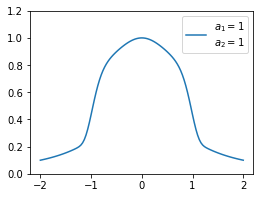

In [4]:
a1 = 1
a2 = 1
x_act = np.linspace(-2,2,121)
y_act = double_selective_activation(x_act, a1=a1,a2=a2)
plt.figure(figsize=(4,3))
plt.gca().plot(x_act,y_act, label='$a_1=1.$\n$a_2=1.$')
plt.gca().set_ylim([0,1.2])
plt.legend()

MAX_LAYER = 24
layer_settings = {
    # make_layer_setting(a1, a2,  admission_threshold, activation_threshold, max_n)
    i: make_layer_setting(a1, a2, 0.1, 0.9, ) for i in range(1,1+MAX_LAYER) # BEST NOW
}

net = SQANN(layer_settings, N)
net.fit_data(X,Y,verbose=20)


In [5]:
simple_evaluation(X,Y,net, header_text='Show fitting on training data', verbose=20)

simple_evaluation()
Show fitting on training data
N_MISSED_ACTIVATIONS:0, N_large_error (>0.1):0
avg error          :     0.0, avg_frac_error          :     0.0 
avg exclusive error:     0.0, avg exclusive frac error:     0.0


In [6]:
_, INTERP_INDICES_test = standard_evaluation(X_test, Y_test, net, get_interp_indices=True)

 i     Layer     |y-y0|                           abs error
[0]    L=1         |(1.0  ) - (1.0  ))|                 0.0      HIT
[1]    L=1         |(1.0  ) - (1.0  ))|                 0.0      HIT
[2]    L=1         |(1.0  ) - (1.0  ))|                 0.0      HIT
[3]    L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[4]    L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[5]    L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[6]    L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[7]    L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[8]    L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[9]    L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[10]   L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[11]   L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[12]   L=2         |(1.0  ) - (1.0  ))|                 0.0      HIT
[13]   L=2         |(1.0  ) - (1.0  ))|    

In [7]:
X_INTERP, Y_INTERP = [], []
INTERP_MEMBER_LIST = []
for i in INTERP_INDICES_test:
    X_INTERP.append(X_test[i,:])
    y_interp,_,_, interp_info = net.SQANN_propagation(X_test[i,:],ALLOW_INTERPOLATION=True)
    Y_INTERP.append(y_interp)
    
    interpolation_ends = []
    for _, info in interp_info.items():
        _, layer_k, this_index = info
        interpolation_ends.append(net.used_indices[layer_k][this_index])
    INTERP_MEMBER_LIST.append(interpolation_ends)
    
X_INTERP, Y_INTERP = np.array(X_INTERP), np.array(Y_INTERP )

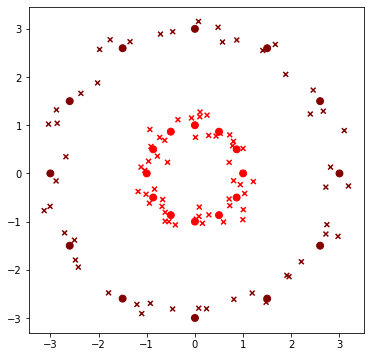

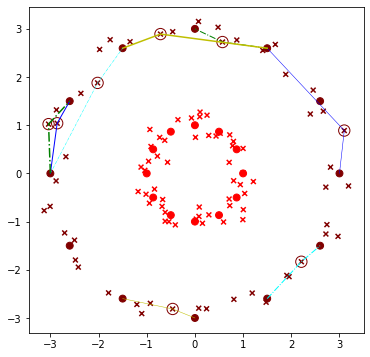

In [8]:
def plot(X,Y, X_test, Y_test, X_INTERP, Y_INTERP, INTERP_MEMBER_LIST, with_annot=True):
    VMAX = 1.5
    plt.figure(figsize=(6,6))
    
    c = np.array([Y,Y*0,Y*0]).T
    plt.gca().scatter(X[:,0],X[:,1],s=48, c=c, vmin=0.,vmax=VMAX,)

    c1 = np.array([Y_test,Y_test*0,Y_test*0]).T
    plt.gca().scatter(X_test[:,0],X_test[:,1],s=24, c=c1, marker='x', vmin=0.,vmax=VMAX,)
    
    if with_annot:
        c2 = np.array([Y_INTERP,Y_INTERP*0,Y_INTERP*0]).T
        plt.gca().scatter(X_INTERP[:,0],X_INTERP[:,1],s=128, facecolors='none' , edgecolors=c2 ,
            linewidth=1, vmin=0.,vmax=VMAX,cmap='Oranges')

        alt_line_style = ['-','-.']
        alt_line_width = [0.5,1., 1.5]
        alt_colors = ['b','g','y','cyan']
        for i, (j,k) in enumerate(INTERP_MEMBER_LIST):
            plt.plot([X[j,0], X_INTERP[i,0] ,X[k,0]],[X[j,1], X_INTERP[i,1] ,X[k,1]], 
                linewidth= alt_line_width[i%len(alt_line_width)] , 
                c=alt_colors[i%len(alt_colors)], 
                linestyle=alt_line_style[i%len(alt_line_style)])

plot(X,Y, X_test, Y_test, X_INTERP, Y_INTERP, INTERP_MEMBER_LIST, with_annot=False)      
plot(X,Y, X_test, Y_test, X_INTERP, Y_INTERP, INTERP_MEMBER_LIST)  